# K-Nearest Neighbors

K-Nearest Neighbors is suitable for this type of classifications as it allows for high classification accuracy even with complex data distributions. Its capacity to support both binary and muti-class classification makes it a very good candidate for estimating room occupancy.


In [1]:
# Import libraries needed
import numpy as np
import pandas as pd
import sklearn
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
%matplotlib inline

## Data Setup

In [2]:
# Read dataset and transform "Room_Occupancy_Count" into a binary colum
df = pd.read_csv('../Occupancy_Estimation.csv')
df["Room_Occupancy_Count"] = [1 if value else 0 for value in df["Room_Occupancy_Count"]]

# Create training an testing datasets
feature_data = df.drop(columns=["Room_Occupancy_Count", "Date", "Time"])
X_train, X_test, Y_train, Y_test = train_test_split(feature_data, df["Room_Occupancy_Count"], test_size=0.2)


## Model Creation

In [3]:
class KNN:
    """
    Class to store data for regression problems 
    """
    def __init__(self, x_train, y_train, K=5):
        """
        Creates a kNN instance

        :param x_train: numpy array with shape (n_rows,1)- e.g. [[1,2],[3,4]]
        :param y_train: numpy array with shape (n_rows,)- e.g. [1,-1]
        :param K: The number of nearest points to consider in classification
        """
        
        # Import and build the BallTree on training features 
        from sklearn.neighbors import BallTree
        self.balltree = BallTree(x_train)
        
        # Cache training labels and parameter K 
        self.y_train = y_train
        self.K = K 
        
        
    def majority(self, neighbor_indices, neighbor_distances=None):
        """
        Given indices of nearest neighbors in training set, return the majority label. 
        Break ties by considering 1 fewer neighbor until a clear winner is found. 

        :param neighbor_indices: The indices of the K nearest neighbors in self.X_train 
        :param neighbor_distances: Corresponding distances from query point to K nearest neighbors. 
        """
        
        while(True):
            label_count = {}
            
            # Get label counts for all datapoint's neighbors
            for i in neighbor_indices:
                label = self.y_train[i]
                if label in label_count:
                    label_count[label] += 1
                else:
                    label_count[label] = 1
            
            # Get first class with highest count
            max_value = max(label_count.values())
            max_key = max(label_count, key=label_count.get)
            
            # Ensure there are no max-count ties
            n_modes = 0
            for x in label_count:
                if(x == max_value):
                    n_modes += 1
            
            # If a tie was detected, remove furthest neighbor and iterate again
            if(n_modes > 1):
                furthest_neighbor = neighbor_distances.index(max(neighbor_distances))
                del neighbor_indices[furthest_neighbor]
                del neighbor_distances[furthest_neighbor]
            else:
                # Otherwise, return class with highest neighbor count
                return max_key
            
        
    def classify(self, x):
        """
        Given a query point, return the predicted label 
        
        :param x: a query point stored as an ndarray  
        """

        # Get neighbors and their distances
        neighbor_distances, neighbor_indices = self.balltree.query(x.reshape(1, -1), k=self.K)

        # Get class with majority representation
        return self.majority(neighbor_indices[0], neighbor_distances[0])        
        
    def predict(self, X):
        """
        Given an ndarray of query points, an ndarray of predictions 

        :param X: an (m x p) dimension ndarray of points to predict labels for 
        """
        return [self.classify(item) for item in X]

## Model Evaluation

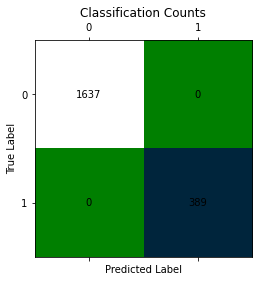

In [4]:
# Create a KNN classifier
knn = KNN(X_train.values, Y_train.values, K=3)

# Get prediction for testing dataset
prediction = knn.predict(X_test.values)

# Calculate confusion matrix
c_matrix = sklearn.metrics.confusion_matrix(Y_test.values, prediction)

# Plot confusion Matrix
fig, ax = plt.subplots()
ax.matshow(c_matrix, cmap='ocean')

# Print classification counts within matrix boxes
for i in range(len(c_matrix)):
   for j in range(len(c_matrix[0])):
      c = c_matrix[j, i]
      ax.text(i, j, str(c), va='center', ha='center')

# Set plot axis titles and show plot
ax.set_xlabel('Predicted Label')
ax.set_ylabel('True Label')
ax.set_title('Classification Counts')
plt.show()

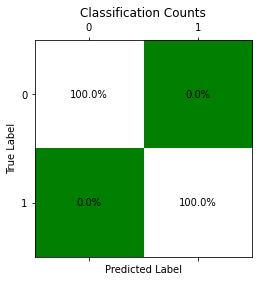

In [5]:
# Create transformed matrix for classification proportions
transformed = np.array( [[1.0]*2]*2)

# Store classification proportions
for i in range(len(c_matrix)):
   for j in range(len(c_matrix[0])):
      transformed[j, i] = c_matrix[j, i] / c_matrix[i].sum()

# Plot confusion Matrix
fig, ax = plt.subplots()
ax.matshow(transformed, cmap='ocean')

# Print classification counts within matrix boxes
for i in range(len(transformed)):
   for j in range(len(transformed[0])):
      c = round(100* transformed[j, i],2)
      ax.text(i, j, str(c) + "%", va='center', ha='center')

# Set plot axis titles and show plot
ax.set_xlabel('Predicted Label')
ax.set_ylabel('True Label')
ax.set_title('Classification Counts')
plt.show()

## Results

As we can see, if the problem is transformed into a binary "Occupied" vs "Empty" scenario, utilizing the KNN classifier we can achieve an  accuracy of 1.000.